# Process "Barriers to Talent" Question Using a LLM

Andrew Weng, 12/30/2024

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [2]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [3]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [4]:
working_list = [] # includes unemployed but previously working
working_and_recruiting_list = [] # those who are working and participate in recruiting
student_list = []

for respondent in analyst.respondents_list:

    if respondent.is_working or respondent.is_unemployed:

        working_list.append(respondent)

        if respondent.company['role_level'] in ['Senior', 'Expert', 'Manager', 'Director/VP', 'Executive']:
            working_and_recruiting_list.append(respondent)

    if respondent.is_student:
        student_list.append(respondent)

print(f'Number of working respondents: {len(working_list)}')
print(f'Number of working respondents who also participate in recruiting: {len(working_and_recruiting_list)}')
print(f'Number of student respondents: {len(student_list)}')

Number of working respondents: 937
Number of working respondents who also participate in recruiting: 487
Number of student respondents: 86


In [6]:
question = dict()
question['tag'] = 'company_skills_barriers_to_talent'
question['question'] = "In your opinion, what do you think are the main barriers to hiring skilled talent in the battery industry?"
question['categories'] = ['Skill Shortage / Lack of Skills in Workforce',
 'Compensation / Salary / Benefits',
 'Location / Relocation Issues',
 'Competition from Other Industries / Companies',
 'Education and Training Gaps',
 'Immigration / Visa Issues',
 'Industry Awareness / Perception',
 'Rapid Industry Growth / High Demand',
 'Company / Industry Stability and Risk']


question['data'] = analyst.summarize_company_skills(working_and_recruiting_list)['barriers_to_talent_list']

print(len(question['data']))


397


In [7]:
question['data']

['Startups are fighting headwinds in terms of market and investment, startup culture is not always the most professional, incumbents are hard to displace',
 'Location   (Michigan? no!)',
 'location, the potential of company or program to succeed, team environment,',
 'no knowledge of tech',
 'Lack of Innovative Thinking & Patience',
 'Unwillingness to consider transferable skills',
 'Not many people with such knowledge.',
 'competition from higher paying companies; physical location constraints',
 'Entreprise projects',
 'Not real qualified engineers on the battery technology and understanding of the systems',
 'Boring field',
 'Too much flux in start up companies related to battery industry',
 'Talents are abundant these days，positions are scarce',
 'Salary',
 'lack of trained professional',
 'Difficult skillset',
 'Knowledge, relevant skills, competitive compensation',
 'availability of talent',
 'Cyclical growing and collapsing market',
 'Availability of talent ready to hit the grou

# Pre-process the user response

Interpret the delimiters

In [8]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):

    print(f"Processing response {i+1} of {len(question['data'])}")

    list_of_strings = llm.delimit_string_of_list(string_of_list)

    print(f'--> {list_of_strings}\n')

    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 397
--> ['market and investment', 'startup culture', 'incumbents']

Processing response 2 of 397
--> ['Location', 'Michigan']

Processing response 3 of 397
--> ['location', 'the potential of company or program to succeed', 'team environment']

Processing response 4 of 397
--> []

Processing response 5 of 397
--> ['Lack of Innovative Thinking', 'Patience']

Processing response 6 of 397
--> ['Unwillingness to consider transferable skills']

Processing response 7 of 397
--> []

Processing response 8 of 397
--> ['competition from higher paying companies', 'physical location constraints']

Processing response 9 of 397
--> ['Entreprise projects']

Processing response 10 of 397
--> ['qualified engineers', 'battery technology', 'understanding of the systems']

Processing response 11 of 397
--> []

Processing response 12 of 397
--> ['flux in start up companies', 'battery industry']

Processing response 13 of 397
--> []

Processing response 14 of 397
--> []

Processing r

# Define categories

In [9]:
if question['categories'] == []:
    categories = llm.define_categories(question['question'], keyword_list, num_categories=20)
    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Skill Shortage / Lack of Skills in Workforce',
 'Compensation / Salary / Benefits',
 'Location / Relocation Issues',
 'Competition from Other Industries / Companies',
 'Education and Training Gaps',
 'Immigration / Visa Issues',
 'Industry Awareness / Perception',
 'Rapid Industry Growth / High Demand',
 'Company / Industry Stability and Risk']


# Assign categories

Process one keyword at a time!

In [10]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list,
                                            keyword,
                                            model='gpt-4o')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'market and investment' (1 of 764)...
Processing response: 'startup culture' (2 of 764)...
Processing response: 'incumbents' (3 of 764)...
Processing response: 'Location' (4 of 764)...
Processing response: 'Michigan' (5 of 764)...
Processing response: 'location' (6 of 764)...
Processing response: 'the potential of company or program to succeed' (7 of 764)...
Processing response: 'team environment' (8 of 764)...
Processing response: 'Lack of Innovative Thinking' (9 of 764)...
Processing response: 'Patience' (10 of 764)...
Processing response: 'Unwillingness to consider transferable skills' (11 of 764)...
Processing response: 'competition from higher paying companies' (12 of 764)...
Processing response: 'physical location constraints' (13 of 764)...
Processing response: 'Entreprise projects' (14 of 764)...
Processing response: 'qualified engineers' (15 of 764)...
Processing response: 'battery technology' (16 of 764)...
Processing response: 'understanding of the syste

In [11]:
print(len(other_list))

109


In [12]:
other_list

[{'result': {'response_text': 'incumbents', 'category': 'Other'}},
 {'result': {'response_text': 'team environment', 'category': 'Other'}},
 {'result': {'response_text': 'Patience', 'category': 'Other'}},
 {'result': {'response_text': 'Entreprise projects', 'category': 'Other'}},
 {'result': {'response_text': 'Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'exposure', 'category': 'Other'}},
 {'result': {'response_text': 'understanding safety challenges',
   'category': 'Other'}},
 {'result': {'response_text': 'candidates work ethic', 'category': 'Other'}},
 {'result': {'response_text': 'bias', 'category': 'Other'}},
 {'result': {'response_text': 'Battery safety', 'category': 'Other'}},
 {'result': {'response_text': 'inflexibility', 'category': 'Other'}},
 {'result': {'response_text': 'Poor job descriptions', 'category': 'Other'}},
 {'result': {'response_text': 'impractical spreadsheet math and planning',
   'category': 'Other'}},
 {'result': {'response_text': 'work-li

In [13]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [14]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Company / Industry Stability and Risk': 56,
             'Location / Relocation Issues': 64,
             'Skill Shortage / Lack of Skills in Workforce': 237,
             'Competition from Other Industries / Companies': 36,
             'Industry Awareness / Perception': 48,
             'Education and Training Gaps': 76,
             'Compensation / Salary / Benefits': 109,
             'Immigration / Visa Issues': 17,
             'Rapid Industry Growth / High Demand': 12,
             '_tot_': 397})

In [15]:
collection

defaultdict(list,
            {'Company / Industry Stability and Risk': ['market and investment',
              'startup culture',
              'the potential of company or program to succeed',
              'flux in start up companies',
              'Cyclical growing and collapsing market',
              'contract length',
              'risk/lack of security',
              'Stage of market 2',
              'Lack of job security',
              'hiring and lay-off fluctuations within the industry',
              'high risk of layoffs',
              'industry complexity',
              'Stable companies',
              'stable industry',
              'Politics in company',
              'weak battery industry',
              'Future perspective in relation to political and business commitment',
              'maturity of the company',
              'battery bubble and economic conditions',
              "lack of large 'well known' companies",
              'shareholders',
       

# Visualize the results

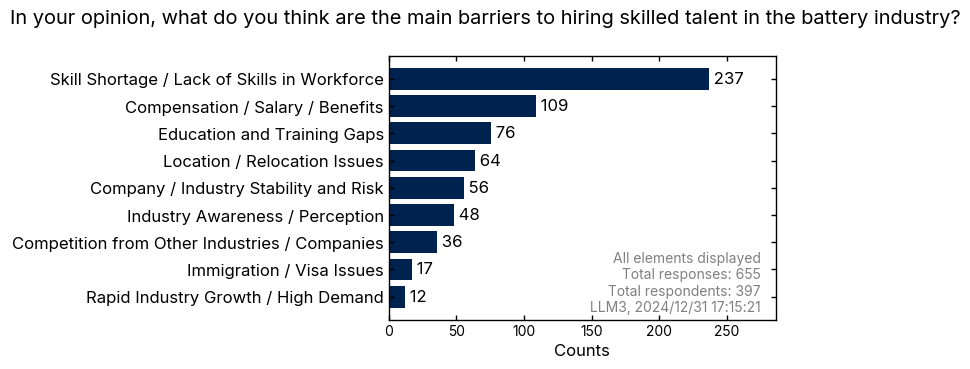

In [16]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_recruiters_{time.strftime("%Y%m%d_%H%M%S")}.png'
)